Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [28]:
from random import choices, sample
import numpy as np
from collections import Counter
from copy import deepcopy
import lab9_lib
from matplotlib import pyplot as plt

In [29]:
PROBLEM_DIM = 10
N_GENERATIONS = 100
POPULATION_SIZE = 30
K_LEN = 1000
PROB_MUTATION = 0.3
N_ELITE = POPULATION_SIZE//10
N_ISLANDS = 5

fitness = lab9_lib.make_problem(PROBLEM_DIM)

In [30]:

class Individual:
    def __init__(self, individual):
        self.individual = individual
        self.fitness = fitness(individual)

    def get_fitness(self) -> str:
        return f"{self.fitness :.2%}"
    
    def equal(self, other):
        return round(self.fitness, 2) == round(other, 2)

    
    

In [31]:
def two_point_crossover(individual1: Individual, individual2: Individual) -> (Individual, Individual):
    c = np.random.randint(1, K_LEN)
    d = np.random.randint(1, K_LEN)
    i1=individual1.individual
    i2=individual2.individual
    if c>d:
        c,d=d,c
    if c!=d:
        for i in range(c, d):
            i1[i], i2[i] = i2[i], i1[i]
    return Individual(i1), Individual(i2)

def uniform_crossover(individual1: Individual, individual2: Individual) -> (Individual, Individual):
    p=0.3
    i1=individual1.individual
    i2=individual2.individual
    for i in range(K_LEN):
        if np.random.random() <= p:
            i1[i], i2[i] = i2[i], i1[i]
    return Individual(i1), Individual(i2)

# def another_crossover(individual1, individual2):
#     # Implementa la logica di crossover tra due genitori
#     crossover_point = np.random.randint(1, K_LEN)
#     child = individual1.individual[:crossover_point] + individual2.individual[crossover_point:]
#     return child

def crossover(individual1: Individual, individual2: Individual):
    return uniform_crossover(individual1, individual2)
    

In [32]:
def mutation(children, probability=0.3):
        p = probability

        new_individual = []
        for i in children:
            if np.random.random() <= p:
                new_individual.append(1-i)
            else:
                new_individual.append(i)
        return Individual(new_individual)

def tournament_selection(population, tournament_size=POPULATION_SIZE//2):
    # return max(np.random.choice(population, size=tournament_size, replace=False), key=lambda i: i.fitness)
    tournament_participants = sample(population, tournament_size)
    winner = max(tournament_participants, key=lambda x: x.fitness)
    return winner





In [33]:
def ga_algorithm(population):
    
                
    avg_fitness = np.average([x.fitness for x in population])
    # count = sum(1 for p in population if p.fitness<avg_fitness)
    # probability = 0.3
    # if count>POPULATION_SIZE//2:
    #     probability = count/POPULATION_SIZE
    
    

    q=population[-N_ELITE:]
    for _ in range((POPULATION_SIZE- N_ELITE)//2):
        p1 = tournament_selection(population)
        p2 = tournament_selection(population)
        if np.random.random() < 0.3:
            

            c1 = mutation(p1.individual, min (0.9, avg_fitness/p1.fitness))
            c2 = mutation(p2.individual, min (0.9, avg_fitness/p2.fitness))
            
         
            # c1 = mutation(p1.individual, probability if p1.fitness<avg_fitness else 0.3)
            # c2 = mutation(p2.individual, probability if p2.fitness<avg_fitness else 0.3)
        else:
            
            c1, c2 = crossover(deepcopy(p1), deepcopy(p2))
        
        q.append(c1)
        q.append(c2)
    population = sorted(q, key=lambda x: x.fitness)

    count_dif = Counter([i.fitness for i in population])

    most_duplicate = count_dif.most_common(1)[0]
   
    
    if most_duplicate[1]>=POPULATION_SIZE//2:
        deleted = 0
        # print("Too much duplicates")
    
        for j in range(POPULATION_SIZE):
            if deleted>=most_duplicate[1]-1:
                break
            if population[j].fitness==most_duplicate[0]:
                population[j]= mutation(population[j].individual)
                deleted+=1

    return population


In [34]:

pop = [sorted([Individual(choices([0, 1], k=K_LEN)) for _ in range(POPULATION_SIZE)], key=lambda x: x.fitness) for _ in range(N_ISLANDS)]


best_individual = max([p[-1] for p in pop], key=lambda x: x.fitness)


counter_extintion = 0

worst_individual = sorted([(i, pop[i][0].fitness) for i in range(N_ISLANDS)], key=lambda x: x[1])[0]

counter_worst = 0

hystory_best_for_island = [[] for _ in range(N_ISLANDS)]
hystory_best = []

for n in range(N_GENERATIONS):
    

    if counter_extintion >= 5 and counter_extintion%5==0:
        probability = min([ 0.3* (counter_extintion/5), 1])
        # print("Extintion with probability", probability, " and counter", counter_extintion)
        print("Extintion")
        n_del = (POPULATION_SIZE-N_ELITE)
        for i in range(N_ISLANDS):

            pop_del = sample(pop[i][: n_del], min(((counter_extintion//10)*n_del)//4, n_del))

            for p in pop_del:
                pop[i].remove(p)
                pop[i].append(Individual(choices([0, 1], k=K_LEN)))
        counter_worst=0
              
        
        # new_c1, new_c2= crossover(deepcopy(pop[min_worst][0]), deepcopy(pop[max_best][-1]))
        
        # pop[min_worst][0], pop[max_best][-1] = mutation(new_c1, probability), mutation(new_c2, probability)

    if counter_worst >= 5:
        print("Worst")
        min_worst = sorted([i for i in range(N_ISLANDS)], key=lambda x: pop[x][0].fitness)
        min_best = sorted([i for i in range(N_ISLANDS)], key=lambda x: pop[x][-1].fitness)

        for i in range(N_ISLANDS):
            if min_worst[i]!=min_best[i]:
                pop[min_worst[i]][0] = pop[min_best[i]][-1]
            else:
                pop[min_worst[i]][0]= mutation(pop[min_best[i]][-1].individual)
        counter_worst = 0


        
    new_worst = worst_individual
    for i in range(N_ISLANDS):
        
        
        pop[i]= ga_algorithm(pop[i])
        
        hystory_best_for_island[i].append(pop[i][-1].fitness)
        if pop[i][0].fitness<new_worst[1] or (i!=new_worst[0] and pop[i][0].fitness==new_worst[1]):
            new_worst = (i, pop[i][0].fitness)
  
    
    if new_worst == worst_individual:
        counter_worst += 1
    else:
        counter_worst = 0

 
    
        # print(f"population{i}, best: {pop[i][-1].fitness:.2%}, worst: {pop[i][0].fitness:.2%}, avg: {avg_fitness:.2%}")
    # print(counter_generation)
    new_best_individual = max([p[-1] for p in pop], key=lambda x: x.fitness)
    hystory_best.append(new_best_individual.fitness)
    
    if new_best_individual.fitness == best_individual.fitness: 
        counter_extintion += 1
    else:
        counter_extintion = 0
    best_individual = new_best_individual
    

    print(f"gen{n}: {best_individual.get_fitness()}")
    if best_individual.fitness == 1:
        break

print(fitness.calls)

gen0: 16.50%
gen1: 16.50%
gen2: 16.50%
gen3: 16.50%
gen4: 16.50%
Worst
gen5: 16.50%
Extintion
gen6: 22.58%
gen7: 22.58%
gen8: 22.58%
gen9: 22.58%
gen10: 22.58%
gen11: 22.58%
Extintion
gen12: 22.58%
gen13: 22.58%
gen14: 22.58%
gen15: 22.58%
gen16: 22.58%
Extintion
gen17: 22.58%
gen18: 22.58%
gen19: 22.58%
gen20: 22.58%
gen21: 22.58%
Extintion
gen22: 22.58%
gen23: 22.58%
gen24: 22.58%
gen25: 22.58%
gen26: 22.58%
Extintion
gen27: 22.58%
gen28: 22.58%
gen29: 26.91%
gen30: 26.91%
gen31: 26.91%
Worst
gen32: 26.91%
gen33: 26.91%
gen34: 26.91%
Extintion
gen35: 26.91%
gen36: 26.91%
gen37: 26.91%
gen38: 26.91%
gen39: 26.91%
Extintion
gen40: 26.91%
gen41: 26.91%
gen42: 26.91%
gen43: 26.91%
gen44: 26.91%
Extintion
gen45: 26.91%
gen46: 26.91%
gen47: 26.91%
gen48: 26.91%
gen49: 26.91%
Extintion
gen50: 26.91%
gen51: 26.91%
gen52: 26.91%
gen53: 26.91%
gen54: 26.91%
Extintion
gen55: 26.91%
gen56: 26.91%
gen57: 26.91%
gen58: 26.91%
gen59: 26.91%
Extintion
gen60: 26.91%
gen61: 26.91%
gen62: 26.91%
gen63:

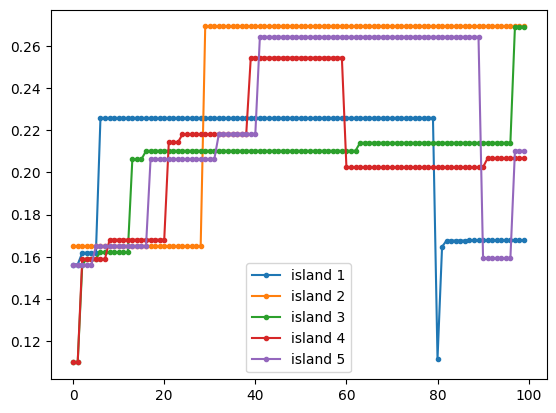

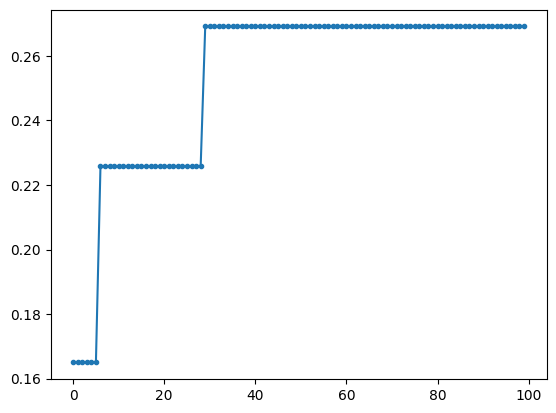

In [35]:
x=[n for n in range(N_GENERATIONS)]
plt.figure()
str_legends = []
for i in range(N_ISLANDS):
    str_legends.append(f"island {i+1}")
    plt.plot(x,hystory_best_for_island[i], marker=".")
plt.legend(str_legends)


plt.figure()
plt.plot(x,hystory_best, marker=".")


popolazione = 50
n_isole = 5
generaioni = 25929
problem_dim = 1
fitness_call = 7852335
RISOLTO!


popolazione = 1000
n_isole = 5
generazioni = 
problem_dim = 1
fitness_call =


In [36]:
sum(1 for i in best_individual.individual if i==1)

527